# Wetlands Insight Tool

* **Products used:**
[usgs_ls8c_level2_2]()

### Background

bcjdclkewc


### Description
xmc,c s

1.  cdc
2.  cdcd
3.  cdc
4.  dcd
5.  dcd

## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

***

### Load packages

In [14]:
import dask
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import datacube
from datacube.utils import geometry
from datacube.utils.dask import start_local_dask
from datacube.utils.rio import configure_s3_access

sys.path.append('../Scripts')
import deafrica_wetlandtools
import deafrica_datahandling

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analysis parameters

In [2]:
shp_path = '../Supplementary_data/Wetlands_insight_tool/WIT_polygons.shp'
time_period = ('2016-01' , '2019-12')
output_dir = ''

### Load shapefile

We will also ensure the polygon is in WGS84 coordinates (`epsg=4326`) using the `to_crs()` method to make sure it can index the datacube correctly.

In [3]:
gdf = gpd.read_file(shp_path).to_crs({'init': 'epsg:4326'}) 
gdf

,Name,geometry
0,Lake_Fitri,"POLYGON ((17.48823 12.98059, 17.58475 12.88522..."
1,Lake_Chad,"POLYGON ((15.24720 13.38406, 15.23333 13.19643..."
2,Lac_de_Korienze,"POLYGON ((-3.76755 15.38105, -3.74466 15.32864..."
3,Burera,"POLYGON ((29.91519 -1.48648, 29.88426 -1.50824..."
4,South_Burera,"POLYGON ((29.88920 -1.52823, 29.91629 -1.52805..."


### Select an individual polygon

We can do this by specifying the name of the polygon we want to interrogate.

In [4]:
wetland_name = 'Lac_de_Korienze'

#index the gdf by the wetland name
poly = gdf[gdf.Name == wetland_name]
poly

,Name,geometry
2,Lac_de_Korienze,"POLYGON ((-3.76755 15.38105, -3.74466 15.32864..."


### Run the Wetlands Insight Tool

Even for small areas, this code can take a long time to run. This is because the tool loads three seperate datasets (Landsat SR, Fractioanl Cover, and WOfS), and calculates the tasselled cap index on the fly.

In [5]:
wetlands_df = deafrica_wetlandtools.WIT_drill(gdf_poly=poly,
                                              time=time_period,
                                              name=wetland_name,
                                              export_csv='wetland_ts.csv')

wetlands_df.head()

 working on polygon: Lac_de_Korienze.  Loading usgs_ls8c_level2_2 data
    Using pixel quality parameters for USGS Collection 2
    Filtering to 57 out of 234 observations
    Applying pixel quality mask
Combining and sorting data
    Returning 57 observations 
size of wetlands array: (500, 519)
calculating tasseled cap index 
Loading WOfS layers 
Loading fractional Cover
Generating classification


,wofs_area_percent,wet_percent,green_veg_percent,dry_veg_percent,bare_soil_percent
2016-02-04 10:37:39.822394,37.48,3.96,6.54,28.18,23.83
2016-03-07 10:37:30.515489,33.11,1.80,1.84,38.64,24.61
2016-04-08 10:37:15.376836,28.38,0.99,0.43,53.85,16.35
2016-05-26 10:37:15.815867,27.44,0.90,0.03,59.54,12.08
2016-07-13 10:37:34.290453,29.04,0.57,0.33,48.83,21.23


## Plot the results

If you would like to export the plot as a .png file, then set the variable below to `True`, and give the plot a `name` (e.g. the wetland's name)

In [6]:
export_plot = True
name = 'Lac_de_Korienze'

<Figure size 432x288 with 0 Axes>

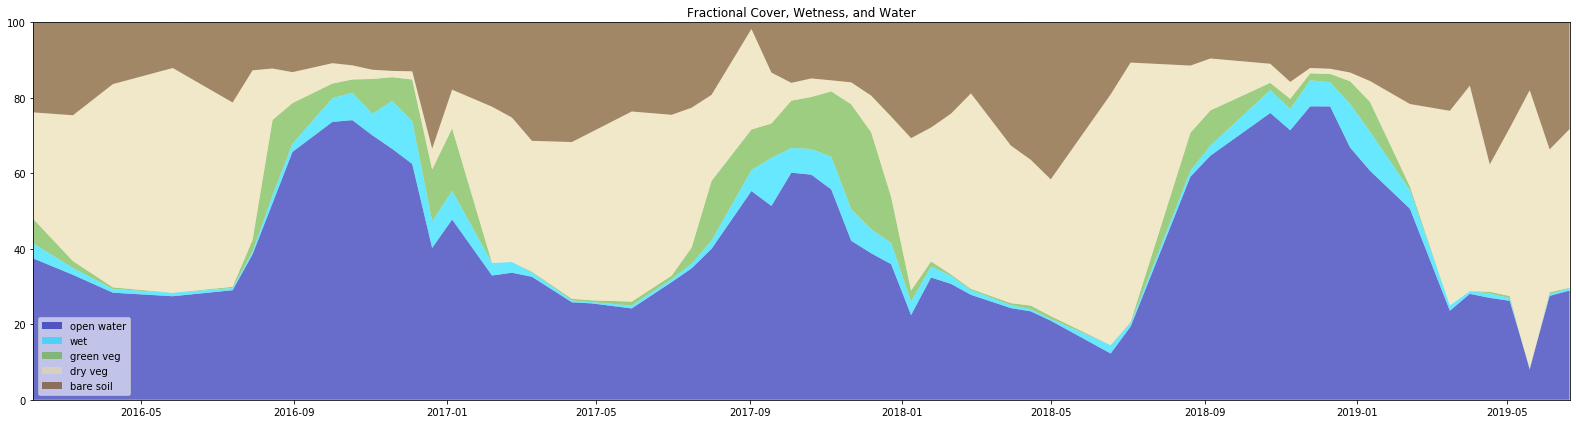

In [7]:
df = wetlands_df

# generate plot
warnings.filterwarnings("ignore")
#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       

#make a stacked area plot
plt.clf()
fig= plt.figure(figsize = (22,6))
plt.stackplot(df.index, 
              df.wofs_area_percent, 
              df.wet_percent, 
              df.green_veg_percent, 
              df.dry_veg_percent,
              df.bare_soil_percent,
              labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                     ], colors=pal, alpha = 0.6)

#set axis limits to the min and max
plt.axis(xmin = df.index[0], xmax = df.index[-1], ymin = 0, ymax = 100)

#add a legend and a tight plot box
plt.legend(loc='lower left', framealpha=0.6)
plt.title('Fractional Cover, Wetness, and Water')
plt.tight_layout()
if export_plot:
    #save the figure
    plt.savefig(f'{name}.png')#, transparent=True)


## Animating the wetland timeseries

Using clear satellite observations over the wetland, we can animate a true-colour satellite timeseries to observe how the wetland has changed over time.

### Set up the datacube query

In [10]:
dc = datacube.Datacube(app='rgb_animation')

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

In [15]:
# Create a query object from the same polygon
# we used for the WIT drill
geom = geometry.Geometry(
        poly.geometry.values[0].__geo_interface__,
        geometry.CRS(
            "epsg:4326")
    )

query = {
    'geopolygon': geom,
    'time': time_period,
    'resolution': (-30,30),
    'group_by': 'solar_day'
}

# find the correct UTM CRS for the location
crs = deafrica_datahandling.mostcommon_crs(dc=dc,
                                          product='usgs_ls8c_level2_2',
                                          query=query)

### Load USGS Landsat data

In [16]:
#Load clear USGS C2 data
col2 = deafrica_datahandling.load_masked_usgs(dc=dc, min_gooddata=0.8,#this number should match WITdrill
                                            products=['usgs_ls8c_level2_2'],
                                            output_crs=crs,
                                            measurements=['red', 'green', 'blue'],
                                            align=(15, 15),
                                            **query)

Loading usgs_ls8c_level2_2 data
    Using pixel quality parameters for USGS Collection 2
    Filtering to 57 out of 157 observations
    Applying pixel quality mask
Combining and sorting data
    Returning 57 observations 


### Animate true-colour and WIT plot

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


    Exporting animation to Lac_de_Korienze_WIT.gif


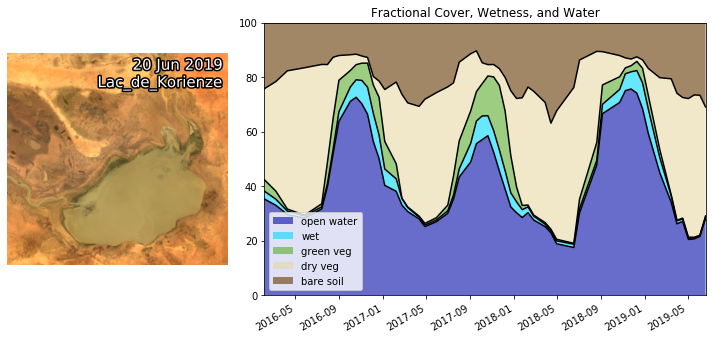

In [17]:
deafrica_wetlandtools.animated_timeseries_WIT(
    col2.rolling(time=3, center=True, min_periods=1).mean(),
    df.rolling(window=3, center=True, min_periods=1).mean(),
    name+ "_WIT.gif",
    width_pixels=1000,
    interval=300,
    show_date=True,
    annotation_kwargs={'fontsize': 15},
    title= name,
)